In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing necessary libraries for data analysis and visualization

import json
from datetime import datetime

import matplotlib.pyplot as plt  # For creating various plots and visualizations
import numpy as np
import pandas as pd  # For handling and manipulating structured data (tables, CSV, etc.)
import seaborn as sns  # For advanced data visualization with statistical capabilities
# Importing automatic data profiling tool
import ydata_profiling as yd  # Used to generate a report with statistics, correlations, and distributions for data exploration
# Importing time series analysis tools from pandas and statsmodels
from pandas.plotting import lag_plot  # For visualizing lag correlations in time series data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Importing seasonal decomposition tool for time series analysis
from statsmodels.tsa.seasonal import  seasonal_decompose  # To decompose a time series into trend, seasonality, and residual components
# Importing statistical test for stationarity
from statsmodels.tsa.stattools import  adfuller  # Augmented Dickey-Fuller (ADF) test to check stationarity of a time series

In [3]:
%matplotlib inline
from pandas.api.types import is_datetime64_any_dtype



In [4]:
# Load the dataset


In [ ]:
df = pd.read_csv(
    "../datasets/BeerWineLiquor.csv",
    parse_dates=True,
)
# Try to detect a datetime column
for col in df.columns:
    df[col] = pd.to_datetime(
        df[col], errors="coerce"
    )  # Convert to datetime if possible
    if is_datetime64_any_dtype(df[col]):
        df.set_index(col, inplace=True)
        print(f"Set '{col}' as the datetime index.")
        break 


Set 'date' as the datetime index.


,beer
date,
1992-01-01,1509
1992-02-01,1541
1992-03-01,1597
1992-04-01,1675
1992-05-01,1822
...,...
2018-08-01,4898
2018-09-01,4598
2018-10-01,4737


In [6]:
DataProfile = yd.ProfileReport(df)
# DataProfile.to_file("Profile.json")
DataProfile.to_file("Profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Basic exploration
print(df.head())
print(df.info())
print(df.describe())



            beer
date            
1992-01-01  1509
1992-02-01  1541
1992-03-01  1597
1992-04-01  1675
1992-05-01  1822
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1992-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   beer    324 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB
None
              beer
count   324.000000
mean   2972.895062
std    1010.218574
min    1501.000000
25%    2109.000000
50%    2791.000000
75%    3627.250000
max    6370.000000


In [8]:
def handle_missing_values(df, validation_fraction=0.1, random_state=42):
    """
    Applies the best missing value imputation strategy based on MSE.
    
    This function creates a validation set by artificially masking a fraction of 
    non-missing values. It then compares several imputation methods by computing 
    the mean squared error (MSE) between the imputed values and the true values 
    at the masked positions. The method with the lowest MSE is applied to the 
    original DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame with possible missing values.
    validation_fraction (float): Fraction of non-missing values to mask for validation.
    random_state (int): Seed for reproducibility.
    
    Returns:
    pd.DataFrame: The DataFrame with missing values imputed.
    """
    # If no missing values, simply return the original dataframe.
    if df.isnull().sum().sum() == 0:
        print("No missing values detected after EDA. Skipping handling.")
        return df
    print("Missing values detected. Selecting best imputation method.")

    # Create a copy of df to simulate additional missingness for validation.
    df_validation = df.copy()
    # This mask DataFrame will track the positions that are artificially set to NaN.
    mask = pd.DataFrame(False, index=df.index, columns=df.columns)
    # For each column, randomly mask a fraction of originally non-missing values.
    np.random.seed(random_state)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df_validation[col] = pd.to_numeric(df_validation[col], errors='coerce')
        non_missing_indices = df[df[col].notnull()].index
        n_to_mask = int(len(non_missing_indices) * validation_fraction)
        if n_to_mask > 0:
            masked_indices = np.random.choice(non_missing_indices, n_to_mask, replace=False)
            mask.loc[masked_indices, col] = True
            df_validation.loc[masked_indices, col] = np.nan

    # Define candidate imputation methods applied on the artificially masked dataframe.
    imputed_dfs = {
        "forward_fill": df_validation.fillna(method='ffill'),
        "backward_fill": df_validation.fillna(method='bfill'),
        "mean_imputation": df_validation.fillna(df_validation.mean()),
        "median_imputation": df_validation.fillna(df_validation.median()),
        "interpolation": df_validation.interpolate()
    }

    mse_scores = {}
    # Compute MSE for each method on the positions we masked.
    for method_name, imputed_df in imputed_dfs.items():
        # y_true holds the ground truth values from the original df where we masked values.
        y_true = df[mask]
        # y_pred holds the corresponding imputed values.
        y_pred = imputed_df[mask]
        mse = np.mean((y_true - y_pred) ** 2)
        mse_scores[method_name] = mse
    print(mse_scores)
    best_method = min(mse_scores, key=mse_scores.get)
    print(f"Selected best missing value handling method: {best_method}")

    # Now apply the best method on the original dataframe with actual missing values.
    if best_method == "forward_fill":
        return df.fillna(method='ffill')
    elif best_method == "backward_fill":
        return df.fillna(method='bfill')
    elif best_method == "mean_imputation":
        return df.fillna(df.mean())
    elif best_method == "median_imputation":
        return df.fillna(df.median())
    elif best_method == "interpolation":
        return df.interpolate()
    else:
        print("No valid imputation method selected, returning original df.")
        return df

'''
def convert_if_majority_numeric(dataframe):
    # print(dataframe)
    df1 = dataframe
    df1.dropna(inplace=True)
    """Convert string numbers to numeric values only if most elements are numeric."""
    for column in df1.columns:
        type_counts = df[column].apply(lambda x: is_numeric_dtype(x)).value_counts()
        for x in df[column]:
            print(type(x))

        # Check if majority is numeric
        majority_is_numeric = type_counts.get(True, 0) > type_counts.get(False, 0)
        print(column, " : ", type_counts.get(True, 0))
        print(
            column,
            " : ",
        )
        print(column, " : ", majority_is_numeric)

        if majority_is_numeric:
            df[column] = pd.to_numeric(
                df[column],
                errors="coerce",
            )  # Convert only if majority is numeric
            print("converted")
'''

'\ndef convert_if_majority_numeric(dataframe):\n    # print(dataframe)\n    df1 = dataframe\n    df1.dropna(inplace=True)\n    """Convert string numbers to numeric values only if most elements are numeric."""\n    for column in df1.columns:\n        type_counts = df[column].apply(lambda x: is_numeric_dtype(x)).value_counts()\n        for x in df[column]:\n            print(type(x))\n\n        # Check if majority is numeric\n        majority_is_numeric = type_counts.get(True, 0) > type_counts.get(False, 0)\n        print(column, " : ", type_counts.get(True, 0))\n        print(\n            column,\n            " : ",\n        )\n        print(column, " : ", majority_is_numeric)\n\n        if majority_is_numeric:\n            df[column] = pd.to_numeric(\n                df[column],\n                errors="coerce",\n            )  # Convert only if majority is numeric\n            print("converted")\n'

In [9]:
df = handle_missing_values(df)
def generate_mlops_report(df):
    """
    Generate a machine-interpretable EDA report for MLOps preprocessing
    
    Parameters:
    df (pandas.DataFrame): Input time series dataframe
    
    Returns:
    dict: Structured, machine-readable analysis report
    """
    report = {
        "dataset_metadata": {
            "total_columns": len(df.columns),
            "total_rows": len(df),
            "date_range": {
                "start": str(df.index.min()),
                "end": str(df.index.max())
            }
        },
        "preprocessing_recommendations": {
            "stationarity": {},
            "feature_scaling": [],
            "feature_engineering": []
        },
        "statistical_insights": {
            "descriptive_stats": {},
            "correlations": {
                "significant_correlations": [],
                "correlation_matrix": {}
            }
        }
    }
    
    # Stationarity Analysis
    for column in df.columns:
        adf_result = adfuller(df[column])
        report["preprocessing_recommendations"]["stationarity"][column] = {
            "is_stationary": str(adf_result[1] < 0.05),
            "p_value": float(adf_result[1]),
            "transformation_needed": "YES" if adf_result[1] >= 0.05 else "NO"
        }
        
        # Recommend transformations if not stationary
        if adf_result[1] >= 0.05:
            report["preprocessing_recommendations"]["feature_engineering"].append({
                "column": column,
                "suggested_transformations": [
                    "log_transformation",
                    "differencing",
                    "rolling_mean_normalization"
                ]
            })
    
    # Descriptive Statistics
    for column in df.columns:
        report["statistical_insights"]["descriptive_stats"][column] = {
            "mean": float(df[column].mean()),
            "std": float(df[column].std()),
            "min": float(df[column].min()),
            "max": float(df[column].max())
        }
    
    # Correlation Analysis
    corr_matrix = df.corr()
    report["statistical_insights"]["correlations"]["correlation_matrix"] = \
        {str(col): {str(subcol): float(corr_matrix.loc[col, subcol]) 
                    for subcol in df.columns} 
         for col in df.columns}
    
    # Significant Correlations
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                correlation = float(corr_matrix.loc[col1, col2])
                if abs(correlation) > 0.5:
                    report["statistical_insights"]["correlations"]["significant_correlations"].append({
                        "features": [col1, col2],
                        "correlation": correlation,
                        "strength": "strong" if abs(correlation) > 0.7 else "moderate"
                    })
    
    # Feature Scaling Recommendations
    for column in df.columns:
        if df[column].std() > 1:  # Suggest scaling for features with high variance
            report["preprocessing_recommendations"]["feature_scaling"].append({
                "column": column,
                "recommended_method": ["standardization", "min_max_scaling"]
            })
    
    return report

# Generate and save the report
final_report = generate_mlops_report(df)

# Save to JSON
with open('mlops_eda_report.json', 'w') as f:
    json.dump(final_report, f, indent=4)

print("MLOps-friendly EDA Report generated and saved to 'mlops_eda_report.json'")

No missing values detected after EDA. Skipping handling.
MLOps-friendly EDA Report generated and saved to 'mlops_eda_report.json'


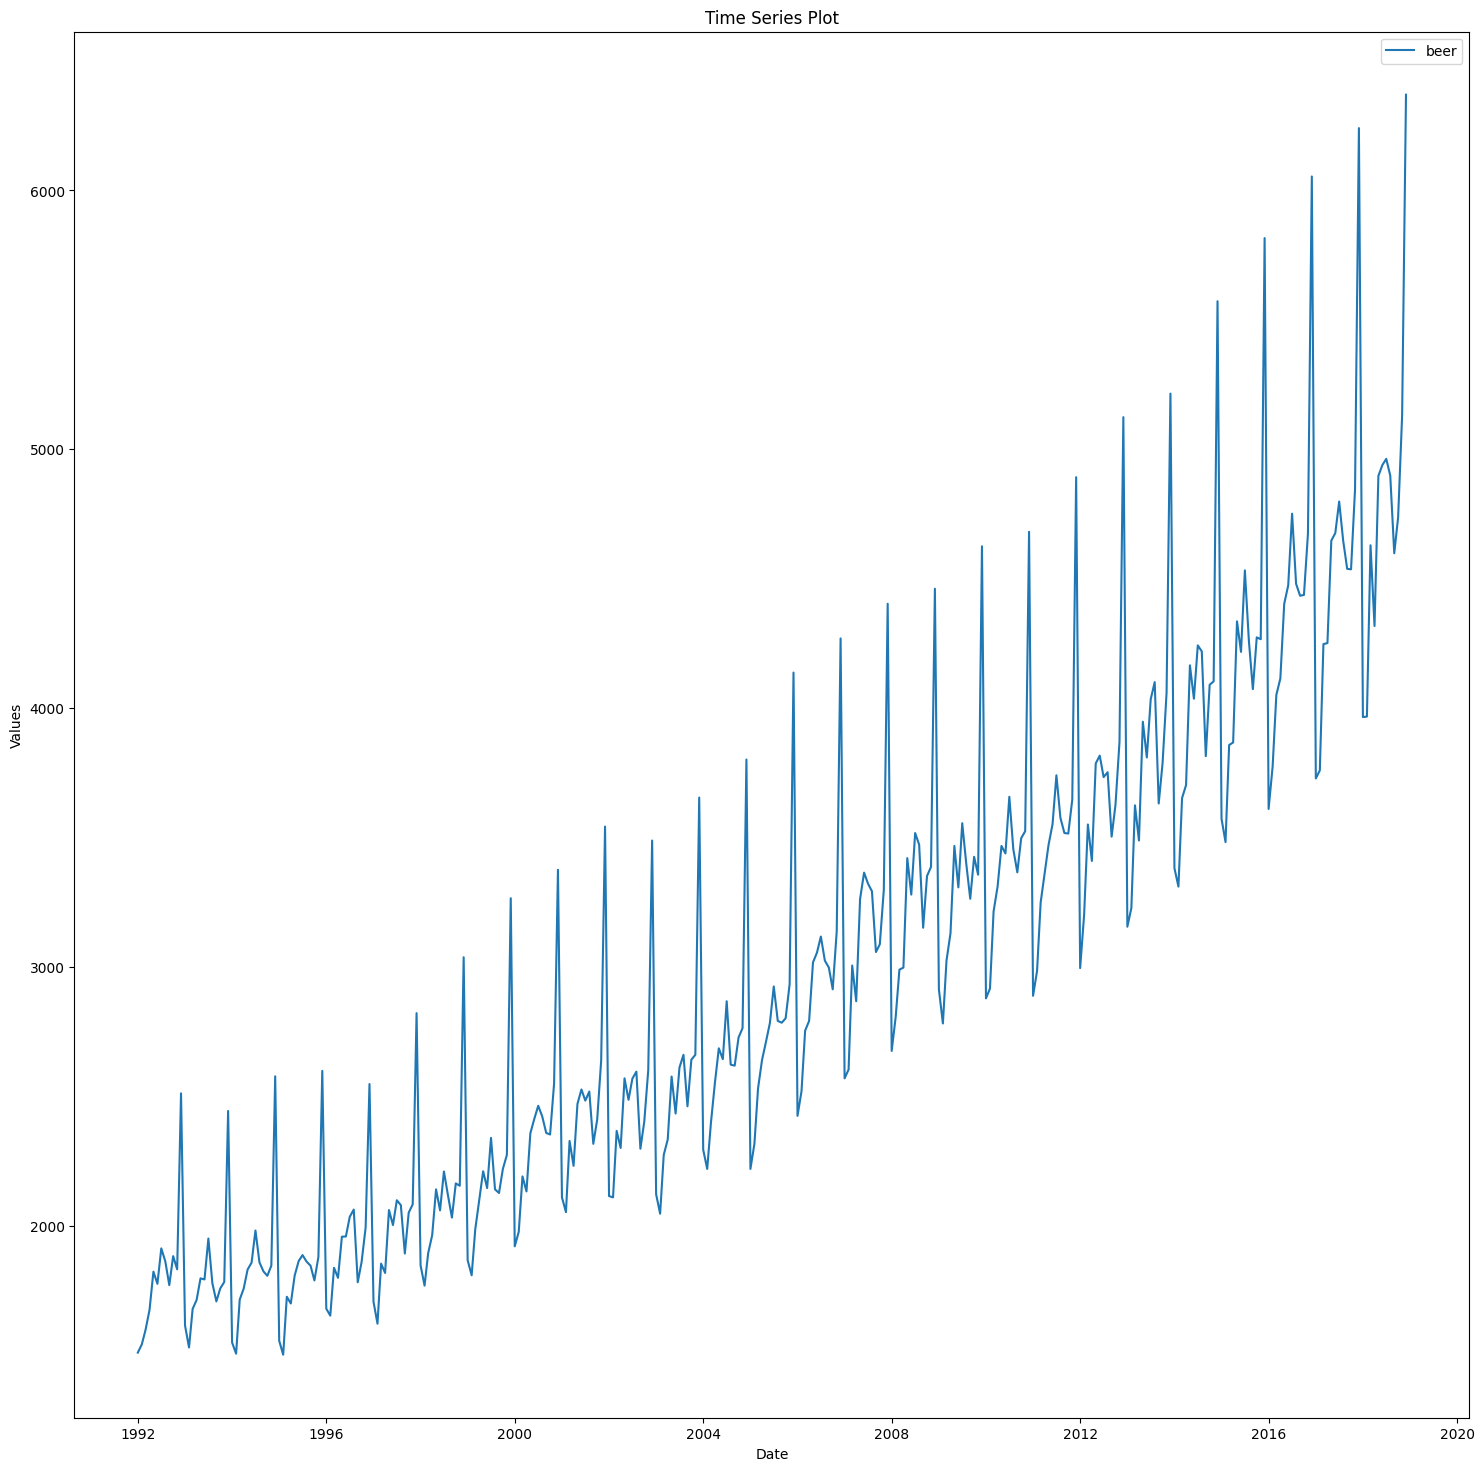

In [10]:
for column in df.columns:
    plt.figure(df.columns.get_loc(column)+1,figsize=(18, 18))
    # Plot the time series data for the current column
    plt.plot(df.index, df[column], label=column)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()



Analyzing column: beer
ADF Statistic for beer: 2.8643085078972637
p-value for beer: 1.0


<Figure size 2000x1400 with 0 Axes>

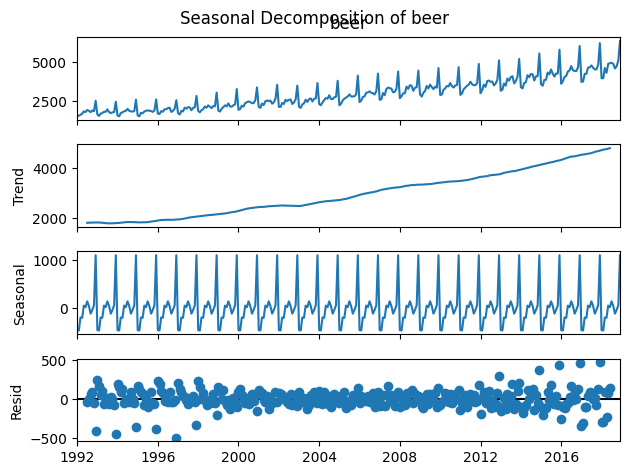

In [11]:

# Loop through each column in the DataFrame to perform stationarity testing and seasonal decomposition
for column in df.columns:
    print(f"\nAnalyzing column: {column}")  # Print the name of the column being analyzed
    
    # Create a new figure for the decomposition plot
    plt.figure(figsize=(20, 14))

    # --- Augmented Dickey-Fuller (ADF) Test for Stationarity ---
    adf_result = adfuller(df[column])  # Perform the ADF test on the current column
    print(f"ADF Statistic for {column}: {adf_result[0]}")  # Print the test statistic
    print(f"p-value for {column}: {adf_result[1]}")  # Print the p-value (to check stationarity)
    
    # The ADF test helps determine if a time series is stationary.
    # If p-value < 0.05, we reject the null hypothesis and conclude that the series is stationary.

    # --- Seasonal Decomposition ---
    # Decompose the time series into trend, seasonality, and residuals using an additive model
    decomposition = seasonal_decompose(df[column], model='additive', period=12)
    
    # Plot the decomposition results (observed, trend, seasonal, and residual components)
    decomposition.plot()
    
    # Set a title for the decomposition plot
    plt.suptitle(f'Seasonal Decomposition of {column}')
    
    # Display the plots
    plt.show()


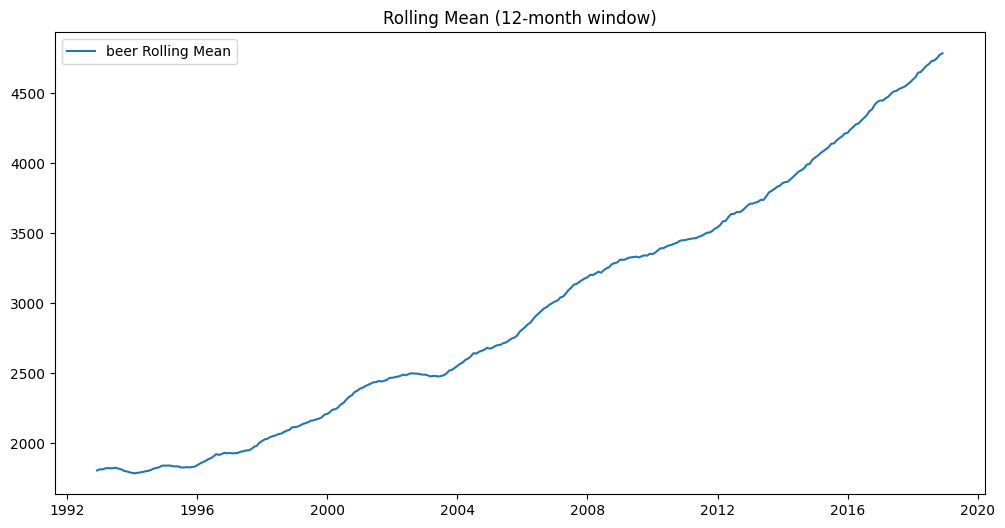

In [12]:
# Compute the rolling mean with a 12-month window for smoothing time series data
rolling_means = df.rolling(window=12).mean()

# Create a new figure with a specific size
plt.figure(figsize=(12, 6))

# Loop through each column in the DataFrame to plot its rolling mean
for column in df.columns:
    plt.plot(rolling_means.index, rolling_means[column], label=f'{column} Rolling Mean')

# Set the title of the plot
plt.title('Rolling Mean (12-month window)')

# Add a legend to indicate which rolling mean corresponds to which column
plt.legend()

# Display the plot
plt.show()



Correlation Matrix:
      beer
beer   1.0


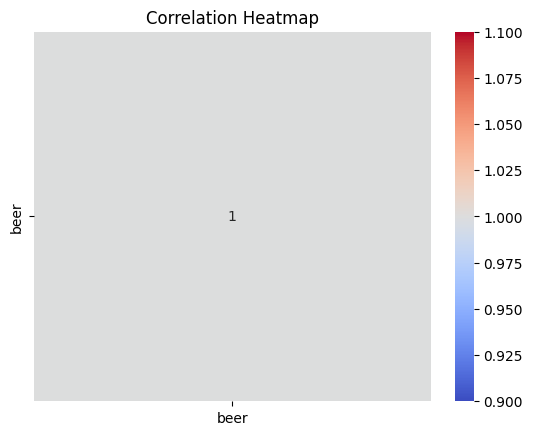

In [13]:
# Compute the correlation matrix for all numerical columns in the DataFrame
df_corr = df.corr()

# Print the correlation matrix to inspect the numerical relationships between variables
print("Correlation Matrix:")
print(df_corr)

# Create a heatmap to visualize the correlation matrix
sns.heatmap(df_corr, annot=True, cmap='coolwarm')

# Set the title for the heatmap
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()



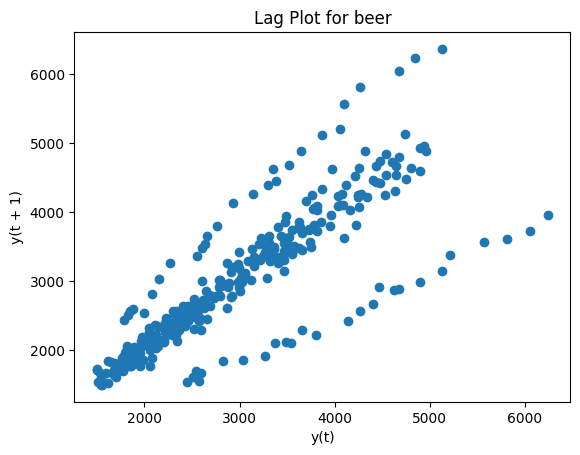

In [14]:
for column in df.columns:
    plt.figure()
    lag_plot(df[column])
    plt.title(f'Lag Plot for {column}')
    plt.show()


Autocorrelation and Partial Autocorrelation for beer


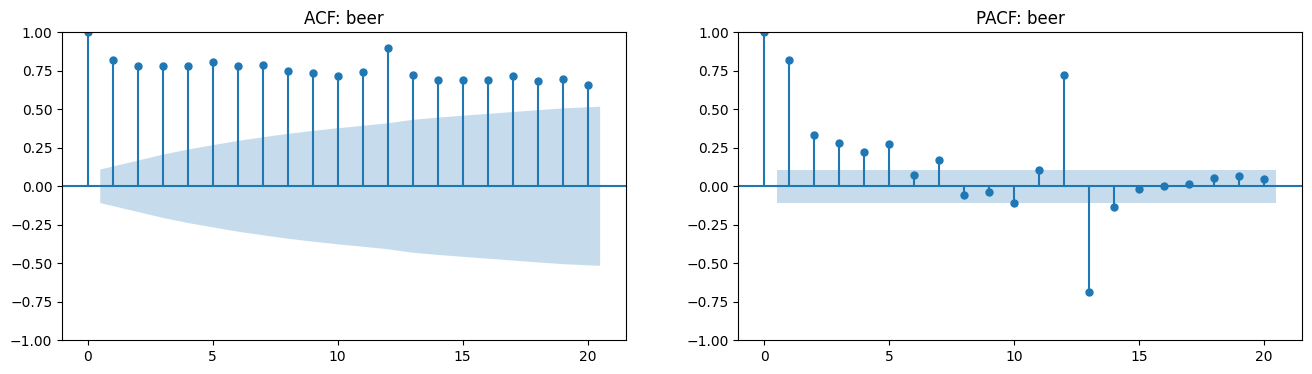

In [15]:
for column in df.columns:
    print(f"Autocorrelation and Partial Autocorrelation for {column}")
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(df[column], ax=axes[0], lags=20, title=f'ACF: {column}')
    plot_pacf(df[column], ax=axes[1], lags=20, title=f'PACF: {column}')
    plt.show()

In [16]:
# Create a new DataFrame with lagged versions of the original columns
lagged_df = pd.concat(
    [df.shift(i).add_suffix(f"_lag{i}") for i in range(1, 4)], axis=1  # Lag 1, 2, 3
)

# Concatenate the original DataFrame with the lagged features and remove any NaN values
lagged_df = pd.concat([df, lagged_df], axis=1).dropna()

# Display the first few rows of the new DataFrame with lagged values
print(lagged_df.head())


            beer  beer_lag1  beer_lag2  beer_lag3
date                                             
1992-04-01  1675     1597.0     1541.0     1509.0
1992-05-01  1822     1675.0     1597.0     1541.0
1992-06-01  1775     1822.0     1675.0     1597.0
1992-07-01  1912     1775.0     1822.0     1675.0
1992-08-01  1862     1912.0     1775.0     1822.0


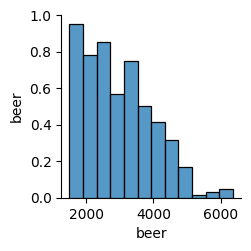

In [17]:
# Create pairwise scatter plots for all numerical columns in the DataFrame
sns.pairplot(df, kind="reg")

plt.show()